In [1]:
#Based on the plots and results, the values which returned the highest accuracy was considered for this script (M, La)
#Import Required packages
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

# Data Preprocessing

In [2]:
# Dataset is seperated into training, validation and test. 
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10

# Regularization parameter to minimize error 
C_Lambda = 0.02


#M is the number of basis function
M = 4

# φ is a vector of M basis functions
PHI = []


# This method reads the target file for all 69623 entries and appends the content to variable, and returns it as a list
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'r') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    return t

#This method processes the raw data file for all 69623 entries and stores all feature set as np array of dimensions 41*69623
#A matrix is built for the feature set. 5 rows are deleted since it contains all zero, and would have no significance on the clustering. 
def GenerateRawData(filePath):  
    dataMatrix = [] 
    with open(filePath, 'r') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    #We delete the columns 5,6,7,8 and 9 because all the entries are zero
    dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)        
    #dataMatrix = [ [0,1,.. 41] [[0,1,.. 41]].... [0,1,.. 41] ]
    return dataMatrix

#Querylevelnorm_t contains the target(t) for 69623 values
#Querylevelnorm_X contains the target(t) for 69623 values
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv')




In [3]:
# This method gets the target value for training set(55699 entries) appends the content to variable, and returns it as a list
# 80% of the actual data (test data) is used here, to compose Traininglength
def GenerateTrainingTarget(rawTraining):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t

# This method constructs the design matrix for training data, a matrix of 41*55699
# 80% of the actual data (test data) is used construct the feature datamatrix
def GenerateTrainingDataMatrix(rawData):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    t = rawData[:,0:T_len]
    return t

#The method assigns target for validation and test dataset. 
# 10% of the actual data (validation data) is used here
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize 
    t =rawData[TrainingCount+1:V_End]
    return t

# This method constructs the design matrix for validation and test data
# 10% of the actual data (validation data) is used here
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    return dataMatrix

# Dataset is seperated into training, validation and test. 
# Training, validation and test is of 80, 10 and 10 percent of the actual data, with no overlap of data entries
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10


#Preparing Training dataset
# It extracts 55699 values from  0th position in the Rawtarget and stores it in an array. 
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget))
#It generates a matrix of 41*55699 for training set
TrainingData   = GenerateTrainingDataMatrix(RawData)

#Preparing validating dataset
## It extracts 6962 values from 55699th position in the Rawtarget and stores it in an in the array.  
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
#It generates a matrix of 41*6962 for validation set
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))

#Preparing Testing dataset
# It extracts 6961 values from 62661th position in the Rawtarget and stores it in an in the array.  
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
#It generates a matrix of 41*6961 for validation set
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))

In [4]:

#Kmeans cluster stores M centroids
#We have M number of individual clusters, and M centroids, with each  
#Mu contains centroids for each basis function, containing detail about all 41 features  
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
#Mu is the cordinate of centroid for each cluster
#Mu is an array of size of (M, 41)
Mu = kmeans.cluster_centers_

In [5]:
#This method generates the variance matrix. It contains 
#So in order to make matrix multiplication feasible, we expand the variance vector (varVect)
#Only the diagonal is filled and rest is zero entries. 
#Thus the bigsigma contains only diagonal entries (variance) and the rest are zero (covariance).

def GenerateBigSigma(Data,TrainingPercent):
    #Returns a 41*41 matrix filled with zeros
    BigSigma    = np.zeros((len(Data),len(Data)))
    #Calculate the transpose of RawData, to get matrix of dimensions 69623*41
    DataT       = np.transpose(Data)
    # The Training dataset entries is 55699
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))    
    #Varvect is the variance vector of dimension 1*41
    #This is expanded to Bigsigma of dimensions 41*41
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])
            #Returns the variance of the array elements
        varVect.append(np.var(vct))
    #Varvect contains the variance and is an list of 41 elements (matrix of 1*41)
    #Bigsigma is 41*41 matrix, extended from varvect. Bigsigma only has diagonal filled and rest is zero
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    BigSigma = np.dot(100,BigSigma)
    #Bigsigma returns the variance matrix
    return BigSigma

#Variance matrix is found using Bigsigma method 
#Variance being a scalar, we generate a Matrix by multiplying variance value for each feature into Identity vector
#Bigsigma is 41*41 matrix, extended from varvect. Bigsigma only has diagonal filled and rest is zero
BigSigma     = GenerateBigSigma(RawData, TrainingPercent)

In [6]:
# Find the scalar product of Gaussian radial basis functions
# Finds  (((x − µj)^-1) (Σ(^-1)(x − µj))) value
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):
    # Find the Gaussian radial basis functions  is φj (x)
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x



# GetPhiMatrix finds Gaussian radial basis functions  is φj (x) = exp (−1/2 (((x − µj)^-1) (Σ(^-1)(x − µj)))) 
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    #Datatranspose is transpose matrix of RawData
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))
    # PHI is filled with zeros with dimensions of TrainingLen and MuMatrix 
    PHI = np.zeros((int(TrainingLen),len(MuMatrix)))
    # BigSigInv is the inverse of BigSigma of same dimensions 41*41
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            # For M values of Mumatrix and 55699 values of Training, generate PHI
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    return PHI

#We build the matrix for the basis function using the φj (x) formula
#Returns an 55699*M matrix dimension
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)

In [7]:
# Pseudo inverse is found, because the matrix is not a square singular matrix. So  Moore-Penrose pseudo-inverse formula is applied 
# w∗ = (λI + (Φ^T)Φ)^(-1))(Φ^T)t

def GetWeightsClosedForm(PHI, T, Lambda):
    #I is created using the np.identity function as a M*M matrix.
    Lambda_I = np.identity(len(PHI[0]))
    #λI is determined for the I matrix of size M*M
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    # Φ^(-1) is found using np functional calls
    # Finds the transpose of the Φ and has dimensions (M, 55699)
    PHI_T       = np.transpose(PHI)
    # (Φ^(-1)).Φ is determined
    # (Φ^(-1)).Φ is reduced to a (M, M) matrix
    PHI_SQR     = np.dot(PHI_T,PHI)
    # (λI + (Φ^T)Φ is calculated 
    # Again PHI_SQR_LI becomes (M, M) matrix
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    # (λI + (Φ^T)Φ ^(-1)
    # PHI_SQR_INV is again a matrix of size (M, M)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    # (λI + (Φ^T)Φ)^(-1))(Φ^T)
    # INTER becomes (M, 55699) because Φ^T is (M, 55699)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    # (λI + (Φ^T)Φ)^(-1))(Φ^T)t is determined
    # w becomes (M,) because of the dot product being involved
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

In [9]:
#Calculate weights for the training dataset
W  = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

#We build the matrix for the basis function for test data using the φj (x) formula
#Returns an 6961*M matrix dimension
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100)

#We build the matrix for the basis function for validation data using the φj (x) formula
#Returns an 6962*M matrix dimension
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

#This method is the determining the target solution (f(x))
#The target is the product of Weights and Phi 
#(N*M)x(M*1) = (N*1) matrix, is the required 
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    return Y

#We calculate the f(x) solution for each Training, validation and test dataset
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)


In [10]:
# This methods calculates the accuarcy of our prediction with the actual target.
# Erms is the square root of the sum of the difference square, divided by total predictions 
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        # Compare the target value and predicted value
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [11]:
# We determine the accuracy of our prediction model
TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

print ('UBITname      = davidjeg')
print ('Person Number = 50290785')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M " + str(M) + "\nLambda " + str(C_Lambda))
# Accuracy is stored in 0th posistion, and Erms is stored in the 1st position
print ("Accuracy Training   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Accuracy Validation = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Accuracy Testing    = " + str(float(TestAccuracy.split(',')[0])))
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

# Overfitting causes increased accuracy in training and validation

----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M 4
Lambda 0.02
Accuracy Training   = 74.51300741485484
Accuracy Validation = 75.15081873024992
Accuracy Testing    = 70.23416175836805
E_rms Training   = 0.5547953358069684
E_rms Validation = 0.5427802627466416
E_rms Testing    = 0.6327717807072879


In [12]:
# The current weight. Initially it is extended from W of closed solution. (W*200 in this case)
W_Now        = np.dot(220, W)

# Lambda is the regularization parameter, added to avoid overfitting
La           = 2

#The Erms is initialized for Train, validation and test  dataset
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []

Acc_L_Erms_Val   = []
Acc_L_Erms_TR    = []
Acc_L_Erms_Test  = []

f = []
g = []

#maximum number of iterations. We consider 300 as the range
#The dimensions of all the steps are (M,1) because of the dimension of W
for i in range(1,300):
    f.append(i)
    learningRate = 1/ math.sqrt(i)    
    print ('---------Iteration: ' + str(i) + '--------------')
    #Delta_E_D is -(t -(w^T)Φ(x))Φ(x)
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    #La_Delta is λW
    La_Delta_E_W  = np.dot(La,W_Now)
    #Delta_E is the addition of the two previous values
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    # - ve sign, because we need to descent for minimizing error value
    Delta_W       = -np.dot(learningRate,Delta_E)
    #W_T_Next and and W_Now are updated with the current values for the next iteration
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #ValTest is the determining the target solution (f(x))
    #The target is the product of Weights and Phi 
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 

    # This methods calculates the accuarcy of our prediction with the actual target.
    # Erms is the square root of the sum of the difference square, divided by total predictions 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    Erms_Test = GetErms(TEST_OUT,TestDataAct)

    #Save the value of Erms
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    g.append(float(Erms_Test.split(',')[1]))
    Acc_L_Erms_TR.append(float(Erms_TR.split(',')[0]))
    Acc_L_Erms_Val.append(float(Erms_Val.split(',')[0]))
    Acc_L_Erms_Test.append(float(Erms_Test.split(',')[0]))

print(float(Erms_Test.split(',')[1]))
print ('----------Gradient Descent Solution--------------------')
print ("Learning rate " + str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

print ("Accuracy Training   = " + str(float(Erms_Test.split(',')[0])))
print ("Accuracy Validation = " + str(float(Erms_Test.split(',')[0])))
print ("Accuracy Testing    = " + str(float(Erms_Test.split(',')[0])))


---------Iteration: 1--------------
---------Iteration: 2--------------
---------Iteration: 3--------------
---------Iteration: 4--------------
---------Iteration: 5--------------
---------Iteration: 6--------------
---------Iteration: 7--------------
---------Iteration: 8--------------
---------Iteration: 9--------------
---------Iteration: 10--------------
---------Iteration: 11--------------
---------Iteration: 12--------------
---------Iteration: 13--------------
---------Iteration: 14--------------
---------Iteration: 15--------------
---------Iteration: 16--------------
---------Iteration: 17--------------
---------Iteration: 18--------------
---------Iteration: 19--------------
---------Iteration: 20--------------
---------Iteration: 21--------------
---------Iteration: 22--------------
---------Iteration: 23--------------
---------Iteration: 24--------------
---------Iteration: 25--------------
---------Iteration: 26--------------
---------Iteration: 27--------------
---------I

---------Iteration: 220--------------
---------Iteration: 221--------------
---------Iteration: 222--------------
---------Iteration: 223--------------
---------Iteration: 224--------------
---------Iteration: 225--------------
---------Iteration: 226--------------
---------Iteration: 227--------------
---------Iteration: 228--------------
---------Iteration: 229--------------
---------Iteration: 230--------------
---------Iteration: 231--------------
---------Iteration: 232--------------
---------Iteration: 233--------------
---------Iteration: 234--------------
---------Iteration: 235--------------
---------Iteration: 236--------------
---------Iteration: 237--------------
---------Iteration: 238--------------
---------Iteration: 239--------------
---------Iteration: 240--------------
---------Iteration: 241--------------
---------Iteration: 242--------------
---------Iteration: 243--------------
---------Iteration: 244--------------
---------Iteration: 245--------------
---------Ite

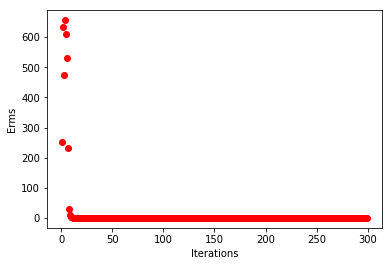

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.56545
E_rms Validation = 0.55427
E_rms Testing    = 0.63633
Accuracy Training   = 74.52198423670085
Accuracy Validation = 75.17954610744039
Accuracy Testing    = 70.23416175836805


In [13]:
# The other graphs in the report were generated on a similar fashion.
import matplotlib.pyplot as plt
plt.plot(f, g, 'ro')
plt.xlabel('Iterations')
plt.ylabel('Erms')
plt.show()


print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy Training   = " + str(float(Erms_TR.split(',')[0])))
print ("Accuracy Validation = " + str(float(Erms_Val.split(',')[0])))
print ("Accuracy Testing    = " + str(float(Erms_Test.split(',')[0])))

